# <font color='#B27AE5'> FORECASTING

 # <font color='#B27AE5'> 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import re
import math
import warnings
import numpy                  as np
import pandas                 as pd
import seaborn                as sns
import matplotlib.pyplot      as plt
import pipeline_class
from src                      import Starts

from statsmodels.tsa.seasonal import STL
from prophet                  import Prophet
from prophet.plot             import plot_cross_validation_metric
from prophet.diagnostics      import cross_validation
from prophet.diagnostics      import performance_metrics
  
from xgboost                  import XGBRegressor

/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mars/.pyenv/versions/3.10.0/envs/pa05/lib/pyth

##  <font color='#B27AE5'>0.1. Helper Functions

In [3]:
starts = Starts()
starts.jupyter_settings()

##  <font color='#B27AE5'> 0.2. Load Data

In [4]:
# Load Data
data_raw = pd.read_csv("data/raw/Ecommerce.csv", encoding='unicode_escape')

# Drop "Unnamed: 8" column
data_raw = data_raw.drop(columns = "Unnamed: 8")

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| InvoiceNo   | Invoice number, a unique identifier for each transaction |
| StockCode   | Product code, a unique identifier for each product       |
| Description | Product description                                     |
| Quantity    | Quantity of products purchased in each transaction      |
| InvoiceDate | Date and time of each transaction                        |
| UnitPrice   | Unit price of each product                              |
| CustomerID  | Customer ID, a unique identifier for each customer       |
| Country     | Country of the customer                                 |


#  <font color='#B27AE5'> 1.0. Data

In [5]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


##  <font color='#B27AE5'> 1.1. Rename Columns

In [6]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


##  <font color='#B27AE5'> 1.2. Data Cleaning

In [7]:
df1.invoice_date = pd.to_datetime(df1.invoice_date)

# Stock_code
stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df1 = df1.query('stock_code not in @stock_code')

# Unit_price
df1 = df1.query('unit_price > 0.01')

##  <font color='#B27AE5'>1.3. Feature Engineering

In [8]:
df1['gross_revenue'] = df1.quantity * df1.unit_price

purchases = df1.groupby('invoice_date')[['gross_revenue']].sum().reset_index()
purchases_series = purchases.set_index(purchases.invoice_date)
purchases_series = purchases.drop(columns='invoice_date')
purchases

,invoice_date,gross_revenue
0,2016-11-29,57378.60
1,2016-11-30,46189.28
2,2016-12-01,43510.73
3,2016-12-03,30957.28
4,2016-12-04,51007.56
...,...,...
300,2017-12-03,79715.11
301,2017-12-04,52931.35
302,2017-12-05,72709.71
303,2017-12-06,76617.42


#  <font color='#B27AE5'>2.0. Time Series Analysis

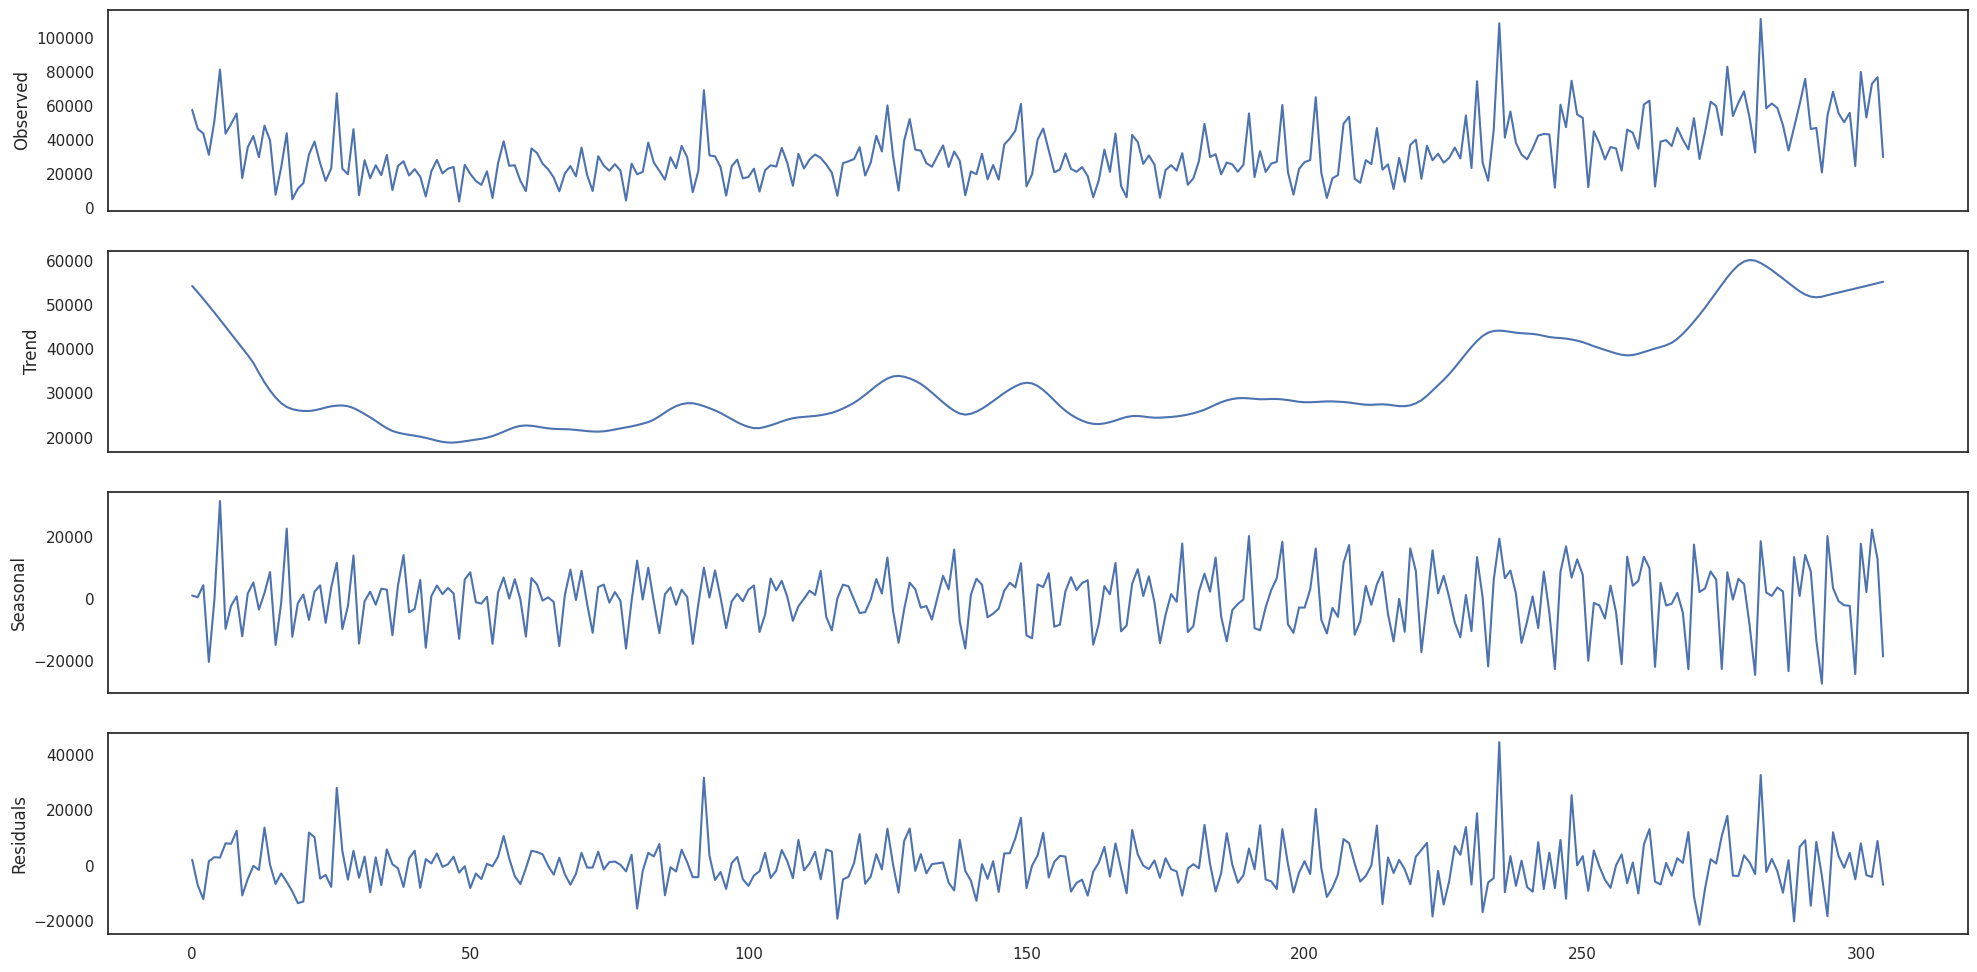

In [9]:
decomp = STL(purchases_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(decomp.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomp.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomp.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomp.resid)
ax4.set_ylabel('Residuals');


#  <font color='#B27AE5'>3.0. Modeling

In [10]:
purchases.columns = ['ds', 'y']

In [11]:
# Check the min max date
print(f'Min date: {purchases.ds.min()}')
print(f'Max date: {purchases.ds.max()}')

Min date: 2016-11-29 00:00:00
Max date: 2017-12-07 00:00:00


In [12]:
# define the date for split
split_date = purchases.ds.max() - pd.Timedelta(days=30)

# split the train and test sets
train = purchases.query('ds <= @split_date')
test  = purchases.query('ds > @split_date')

# check the dimensions
train.shape, test.shape

((279, 2), (26, 2))

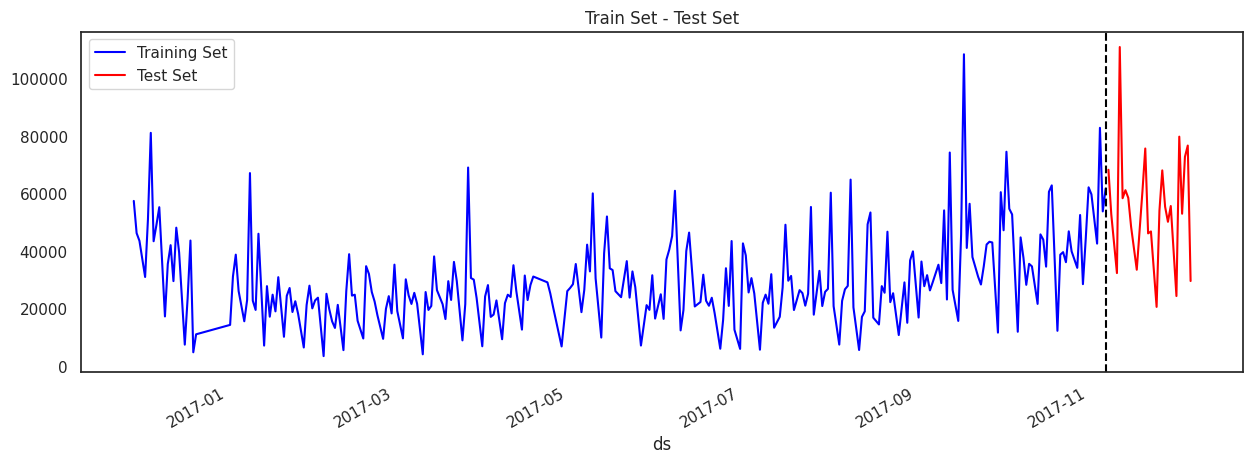

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(x='ds', y='y', ax=ax, label='Training Set', color='blue')
test.plot(x='ds', y='y', ax=ax, label='Test Set', color='red')
plt.axvline(split_date, color='black', ls='--')
plt.legend(['Training Set', 'Test Set'])
plt.title('Train Set - Test Set')
plt.show()

## <font color='yellow'> 3.1. Baseline

In [14]:
def mape(y_true, y_pred):
    """
    Perform the Mean absolute percentage error.
    """
    y_true = y_true.values
    y_pred = y_pred.values
    return np.mean( np.abs((y_true - y_pred) / y_true) )

In [15]:
baseline = pd.Series([train.y.mean()] * len(test))
print(f'The MAPE for baseline is: {(mape( test.y, baseline)*100):.2f}%')

The MAPE for baseline is: 43.22%


## <font color='lighblue'> 3.1. Prophet

In [16]:
# Instancing Prophet
prophet = Prophet()

# Fit the model
prophet.fit(train)

18:38:59 - cmdstanpy - INFO - Chain [1] start processing
18:38:59 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Creating Date Range for predict
future = prophet.make_future_dataframe(periods=78,freq="D", include_history=False)
future

,ds
0,2017-11-08
1,2017-11-09
2,2017-11-10
3,2017-11-11
4,2017-11-12
...,...
73,2018-01-20
74,2018-01-21
75,2018-01-22
76,2018-01-23


In [18]:
# Predict 
forecast = prophet.predict(pd.DataFrame(test.ds))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
21,2017-12-03,48795.898113,33716.664423,64623.727008
22,2017-12-04,54165.400582,39055.553656,69383.357157
23,2017-12-05,48409.953432,32443.516703,63677.766359
24,2017-12-06,55841.908552,41105.937579,72097.859561
25,2017-12-07,48310.521212,32819.262239,64429.851969


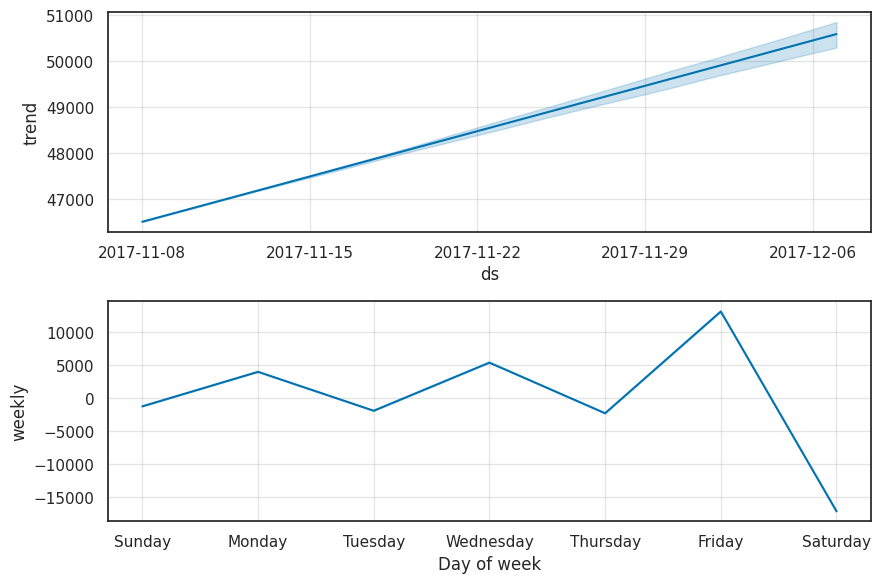

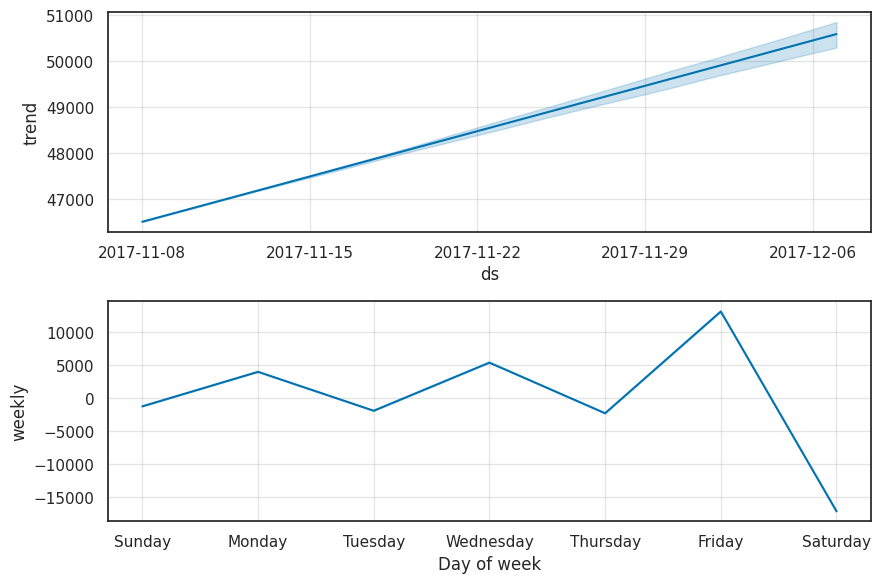

In [19]:
prophet.plot_components(forecast)

In [20]:
print(f'The MAPE for predict is: {(mape( test.y, forecast.yhat)*100):.2f}%')

The MAPE for predict is: 21.73%


### <font color='lighblue'> 3.1.1. CV Prophet

In [21]:
prophet = Prophet()
prophet.fit(train)

18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
df_cv = cross_validation(prophet, initial='90 days', period='28 days', horizon = '28 days')
df_cv

  0%|          | 0/9 [00:00<?, ?it/s]

18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing
18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing
18:39:01 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1] done processing
18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:02 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-01,14598.117958,946.157068,27468.294485,35241.37,2017-02-28
1,2017-03-02,17743.319824,3938.764902,30945.851944,19121.54,2017-02-28
2,2017-03-04,-1769.874509,-14997.158001,12147.864115,9630.28,2017-02-28
3,2017-03-05,15420.899047,1862.574815,28926.769379,30138.84,2017-02-28
4,2017-03-06,22906.113686,8953.309124,36183.554584,24580.88,2017-02-28
...,...,...,...,...,...,...
204,2017-11-02,37253.671558,22818.058714,52704.960633,59657.27,2017-10-10
205,2017-11-04,23321.432052,8108.412518,38894.242953,42552.66,2017-10-10
206,2017-11-05,38116.860841,22383.588426,53538.591334,82778.60,2017-10-10
207,2017-11-06,45232.021452,30293.391949,59934.746391,53741.75,2017-10-10


In [23]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,8.176191e+07,9042.229503,5935.594027,0.359779,0.078832,0.349777,0.950000
1,5 days,7.037179e+07,8388.789801,6093.268567,0.369757,0.090169,0.363883,0.850000
2,6 days,3.444088e+08,18558.255268,10131.682180,0.344425,0.177838,0.341022,0.700000
3,7 days,3.471840e+08,18632.873746,10678.099397,0.303843,0.220817,0.306937,0.757143
4,8 days,1.912416e+08,13829.013110,10311.873270,0.304512,0.364622,0.325277,0.766667
5,9 days,1.766154e+08,13289.671678,11167.359551,0.391010,0.348181,0.366734,0.688889
6,11 days,1.604016e+08,12664.977163,10773.609702,0.600012,0.463420,0.566745,0.716667
7,12 days,1.154848e+08,10746.385774,8875.842929,0.532946,0.334940,0.518498,0.800000
8,13 days,6.603280e+07,8126.057079,6317.164225,0.296870,0.226190,0.290011,0.866667
9,14 days,6.427928e+07,8017.435755,6365.014802,0.233809,0.151012,0.237248,0.887500


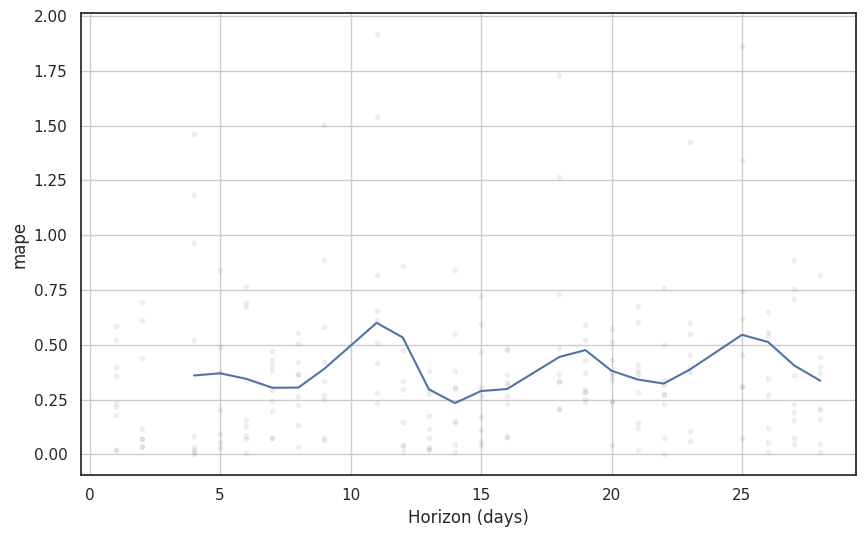

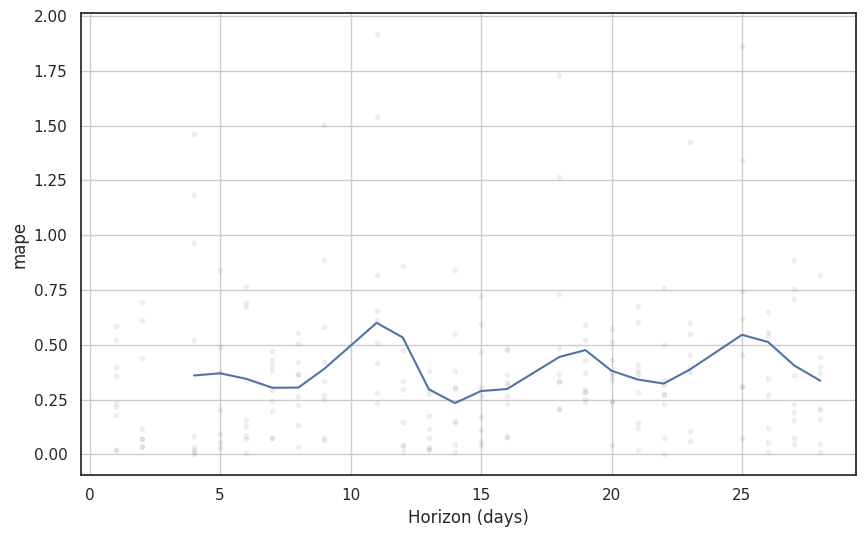

In [24]:
plot_cross_validation_metric(df_cv, 'mape')

## <font color='grenn'> 3.2. XGBoost

In [25]:
purchases_copy = purchases.copy()

### <font color='grenn'> 3.2.1. Time Series Cross Validation


In [26]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=28, gap=0)
purchases_copy = purchases_copy.sort_index()

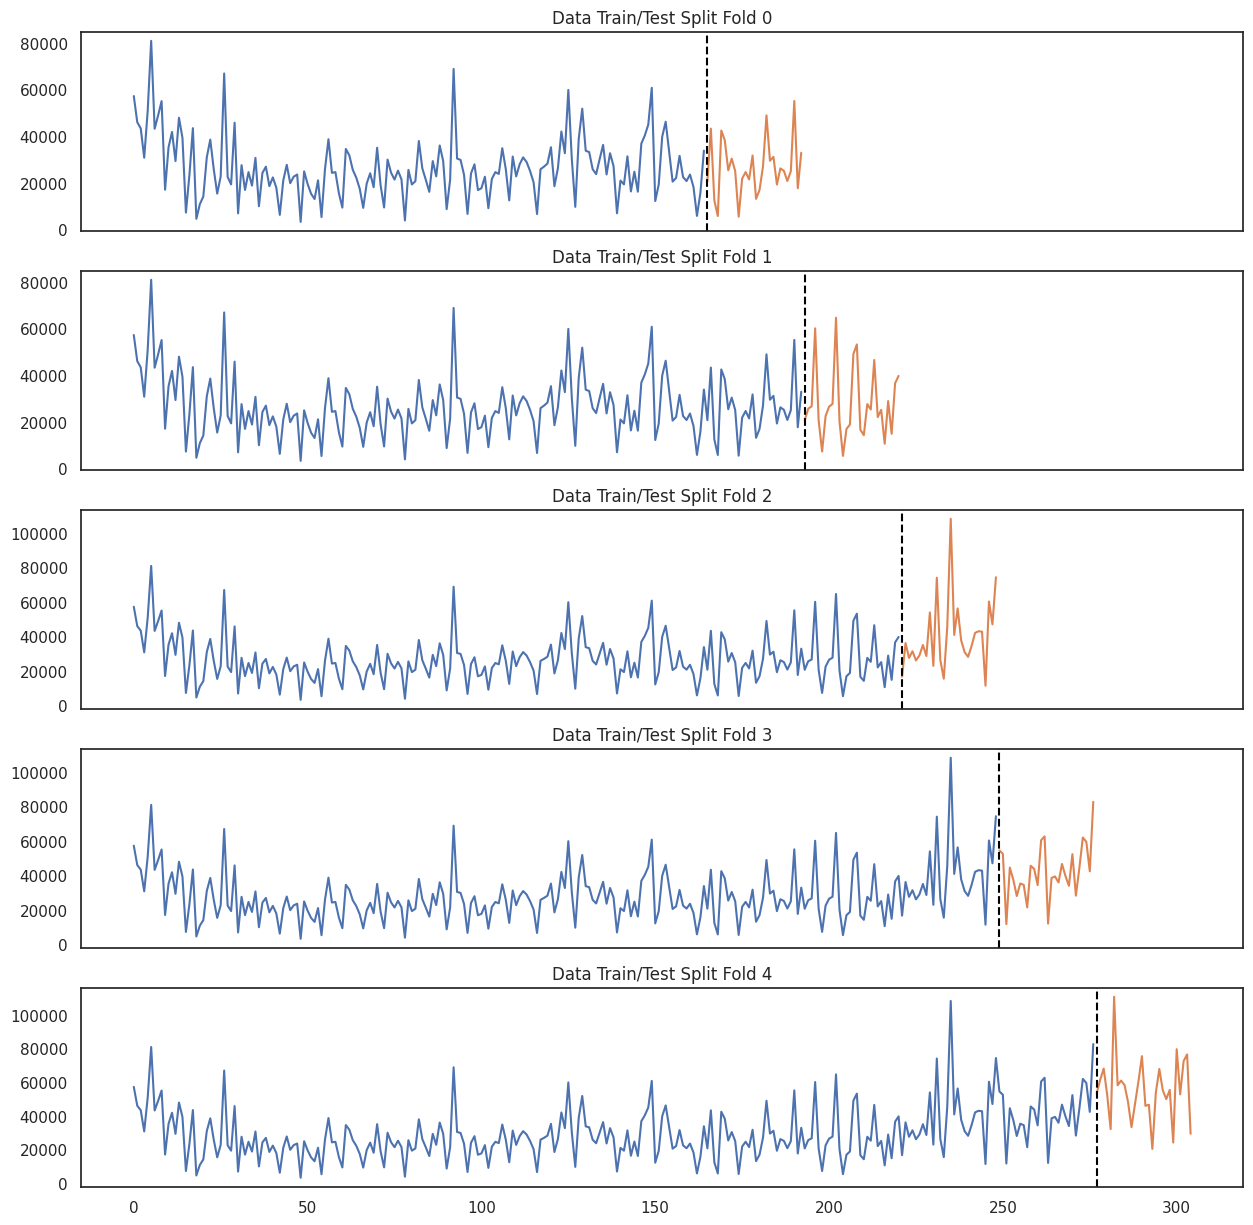

In [27]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(purchases_copy):
    train = purchases_copy.iloc[train_idx]
    validation = purchases_copy.iloc[val_idx]
    train['y'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    validation['y'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(validation.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### <font color='grenn'> 3.2.2. Forecasting Horizon Explained </font>
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [28]:
def feature_engineering( data ):
    """
    Perform date features.
    """
    data['day'] = data.ds.dt.day
    data['day_of_week'] = data.ds.dt.day_of_week
    data['day_of_year'] = data.ds.dt.day_of_year
    data['week'] = data.ds.dt.week
    data['month'] = data.ds.dt.month
    data['quarter'] = data.ds.dt.quarter
    data['year'] = data.ds.dt.year
    data = data.set_index(data.ds)
    data = data.drop(columns= 'ds')

    return data

In [29]:
purchases_copy = feature_engineering( purchases_copy )

### <font color='grenn'> 3.2.3. Lag Features</font>
What was the target (x) days in the past.

In [30]:
def add_lags(df):
    target_map = df['y'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('84 days')).map(target_map)
    
    return df

In [31]:
purchases_copy = add_lags(purchases_copy)

### <font color='grenn'> 3.2.4. Train Using Cross Validation

In [33]:
tss = TimeSeriesSplit(n_splits=5, test_size=28, gap=0)
purchases_copy = purchases_copy.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(purchases_copy):
    train = purchases_copy.iloc[train_idx]
    test = purchases_copy.iloc[val_idx]

    FEATURES = ['day', 'day_of_week', 'day_of_year', 'week', 'month', 'quarter', 'year',
                'lag1','lag2','lag3']
    TARGET = 'y'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=700,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = pd.Series(reg.predict(X_test))
    preds.append(y_pred)
    score = np.sqrt(mape(y_test, y_pred))
    scores.append(score)

[18:39:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29417.44967	validation_1-rmse:28623.77849
[100]	validation_0-rmse:13929.48632	validation_1-rmse:13670.11565
[200]	validation_0-rmse:8906.32206	validation_1-rmse:11266.64956
[266]	validation_0-rmse:7645.02967	validation_1-rmse:11303.50347
[18:39:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29308.11503	validation_1-rmse:31174.76432
[100]	validation_0-rmse:13977.18252	validation_1-rmse:13351.07472
[200]	validation_0-rmse:9140.57776	validation_1-rmse:12442.78244
[214]	validation_0-rmse:8822.51981	validation_1-rmse:12638.03209
[18:39:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29565.21582	validation_1-rmse:44883.18074
[100]	validation_0-rmse:14325.59895	validation_1-rmse:27100

In [35]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.5944
Fold scores:[0.6423551450756224, 0.6948253976247606, 0.5800257511998379, 0.609736519219166, 0.4449350032579686]


In [38]:
# define the date for split
split_date = purchases.ds.max() - pd.Timedelta(days=30)

data = feature_engineering( purchases )
data = add_lags(data)

# split the train and test sets
train = data.query('ds <= @split_date')
test  = data.query('ds > @split_date')

# check the dimensions
train.shape, test.shape

((279, 11), (26, 11))

In [39]:
FEATURES = ['day', 'day_of_week', 'day_of_year', 'week', 'month', 'quarter', 'year',
            'lag1','lag2','lag3']
TARGET = 'y'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [40]:
reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=700,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)

reg.fit(X_train, y_train)
yhat = pd.Series(reg.predict(X_test))

print(f'The MAPE for predict is: {(mape( y_test, yhat)*100):.2f}%')

The MAPE for predict is: 20.40%
